In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import seaborn as sns

plt.style.use('fivethirtyeight')

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

## Helper Functions

In [3]:
def get_csv(chamber, congress):
    fpath = '../congress-data/%s/%s_%d.csv' % (chamber, chamber, congress)
    cong_df = pd.read_csv(fpath, index_col=0)
    cong_df = cong_df.reset_index()
    
    cong_df['PCT'] = cong_df['missed_votes'] / cong_df['total_votes']
    
    if chamber == 'house':
        inds = cong_df['at_large'] == True
        cong_df.loc[inds, 'district'] = '0'
    
    return cong_df

# Exploring Why Senators Miss Roll-Call Votes


## Plotting The Initial Data

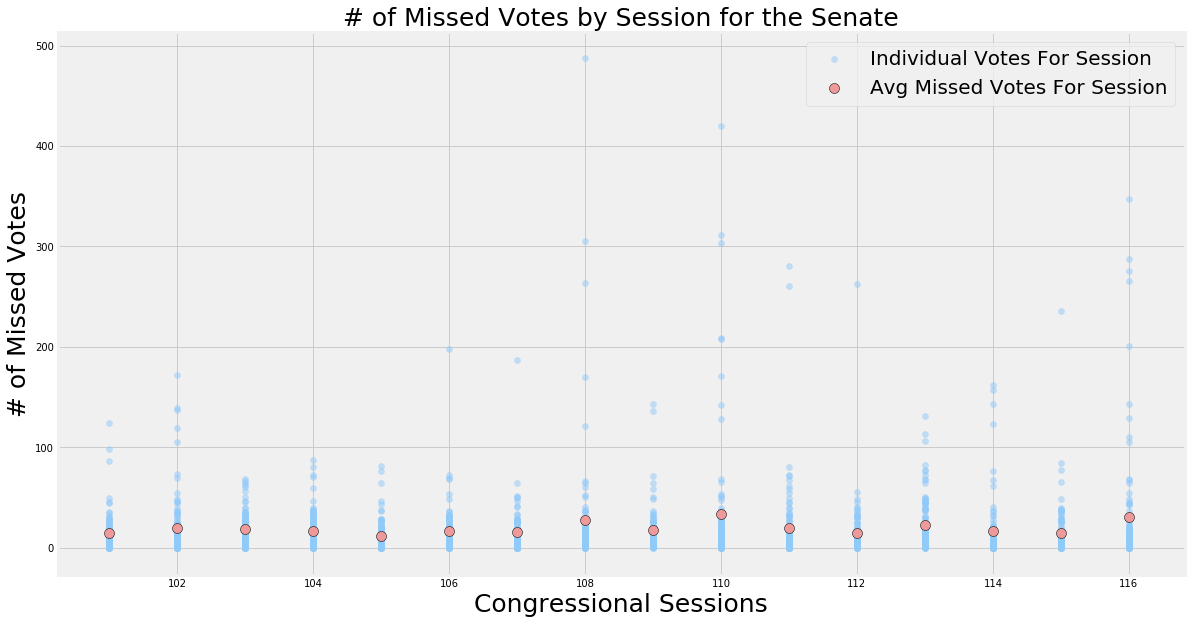

In [4]:
fig, ax = plt.subplots(figsize=(18, 10))
for session in range(101, 117):
    if session == 101:
        total_label = 'Total Votes For Session'
        avg_label = 'Avg Missed Votes For Session'
        ind_label = 'Individual Votes For Session'

    else:
        total_label = ''
        avg_label = ''
        ind_label = ''

    data = get_csv('senate', session)        
    missed_votes = data['missed_votes']
    sessions = np.full((len(missed_votes),), session)
    avg = np.mean(missed_votes)
    ax.scatter(sessions, missed_votes, alpha=0.5, c='#90CAF9', label=ind_label)
    ax.scatter(session, avg, alpha=1, c='#EF9A9A', edgecolor='black', s=100, label=avg_label)

ax.set_xlabel('Congressional Sessions', fontsize=25)
ax.set_ylabel('# of Missed Votes', fontsize=25)
ax.set_title('# of Missed Votes by Session for the Senate', fontsize=25)
ax.legend(prop={'size' : 20});

It looks like the average number of missed votes between sessions does not change too much. For the most part, the data appears to be very low, with a few outliers. 

Lets compute a 5 number summary and plot the data in a seaborn boxenplot.

5 Number Summary for the Senate
101st Congress - 116th Congress
      | Missed Votes
------+------------
Min:  |    0
Q1:   |    4
Med:  |    10
Q3:   |    21
Max:  |    488




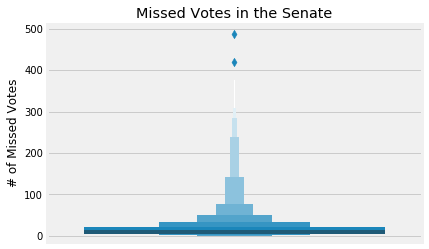

In [5]:
missed_votes = []
for session in range(101, 117):
    df = get_csv('senate', session)
    missed_votes.extend(df['missed_votes'])

missed_q = np.percentile(missed_votes, [25, 50, 75])

missed_min = np.min(missed_votes)

missed_max = np.max(missed_votes)

print('5 Number Summary for the Senate')
print('101st Congress - 116th Congress')
print('===============================')
print('      | Missed Votes')
print('------+------------')
print('Min:  |    %d' % (missed_min))
print('Q1:   |    %d' % (missed_q[0]))
print('Med:  |    %d' % (missed_q[1]))
print('Q3:   |    %d' % (missed_q[2]))
print('Max:  |    %d' % (missed_max))
print('\n')

fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.boxenplot(missed_votes, ax=ax, orient='v')
ax.set_title('Missed Votes in the Senate')
ax.set_ylabel('# of Missed Votes');

The boxenplot gives us a good idea of what the distribution of missed votes is. It seems like the vast majority of missed votes is under 100, but there are a few that are strikingly high. Lets try and figure out whats going on with those senators by filtering out all instances where missed votes < 100 and printing out the resulting names.

In [6]:
print('100+ Missed Votes')
print('=================')
for i in range(101, 117):
    data = get_csv('senate', i)
    data = data[data['missed_votes'] > 100]
    for idx, row in data.iterrows():
        print(row['first_name'] + ' ' + row['last_name'])

100+ Missed Votes
Spark Matsunaga
Albert Gore
Tom Harkin
Jesse Helms
J. Robert Kerrey
David Pryor
John McCain
Jesse Helms
John Edwards
Bob Graham
John Kerry
Joseph Lieberman
Zell Miller
Jon Corzine
John Rockefeller
Joseph Biden
Sam Brownback
Hillary Clinton
Christopher Dodd
Tim Johnson
Edward Kennedy
John McCain
Barack Obama
Robert Byrd
Edward Kennedy
Mark Kirk
Tom Coburn
Thad Cochran
Frank Lautenberg
Ted Cruz
Lindsey Graham
Marco Rubio
Bernard Sanders
John McCain
Lamar Alexander
Michael Bennet
Cory Booker
Kirsten Gillibrand
Kamala Harris
Johnny Isakson
Amy Klobuchar
Bernard Sanders
Elizabeth Warren


Just looking at these names, it seems like quite a few of the people on this list were presidential candidates at one point or another. Maybe their high counts of missed votes correlate with presidential campaigns?

Here is a dictionary containing the names of every single senator who has run for president during the past 30 years. The keys are their names and the values are their unique identifiers.

In [7]:
names_to_ids = {'Gore': 'G000321', 'Harkin': 'H000206', 'Kerrey': 'K000146', 'McCain': 'M000303',
                'Edwards': 'E000286', 'Bob Graham': 'G000352', 'Kerry': 'K000148', 'Lieberman': 'L000304',
                'Biden': 'B000444', 'Brownback': 'B000953', 'Clinton': 'C001041', 'Dodd': 'D000388',
                'Obama': 'O000167', 'Cruz': 'C001098', 'Rubio': 'R000595', 'Sanders': 'S000033',
                'Lindsey Graham' : 'G000359', 'Bennet': 'B001267', 'Booker': 'B001288',
                'Gillibrand': 'G000555', 'Harris': 'H001075', 'Klobuchar': 'K000367', 'Warren': 'W000817'}

Here is a dictionary containing the congressional sessions in which senators ran for president over the last 15 sessions. The keys are the congressional session and the values are the unique identifiers of the candidates.

In [8]:
sessions_to_ids = {102: ['G000321', 'H000206', 'K000146'],
                   106: ['M000303'],
                   110: ['M000303', 'B000444', 'B000953', 'C001041', 'D000388', 'O000167'],
                   108: ['E000286', 'G000352', 'K000148', 'L000304'],
                   114: ['C001098', 'R000595', 'S000033', 'G000359'],
                   116: ['S000033', 'B001267', 'B001288', 'G000555', 'H001075', 'K000367', 'W000817']}

Let's recreate the same plot as above, but this time lets mark every senator who was actively running for president during that congressional session.

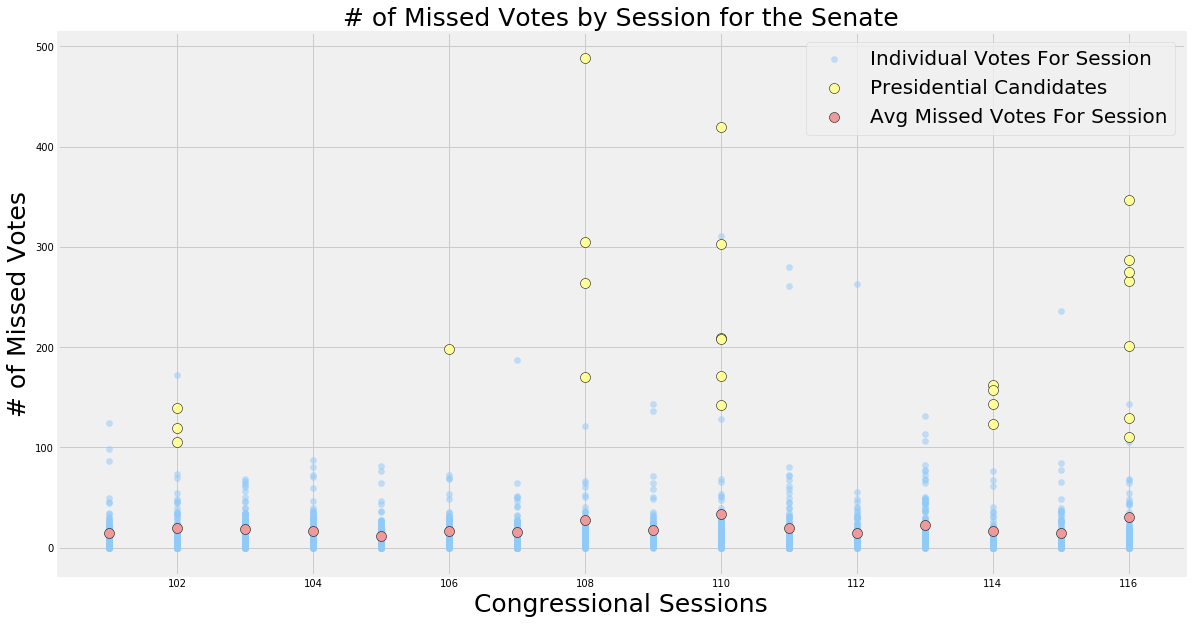

In [9]:
fig, ax = plt.subplots(figsize=(18, 10))
for session in range(101, 117):
    if session == 102:
        total_label = 'Total Votes For Session'
        avg_label = 'Avg Missed Votes For Session'
        ind_label = 'Individual Votes For Session'
        cand_label = 'Presidential Candidates'

    else:
        total_label = ''
        avg_label = ''
        ind_label = ''
        cand_label = ''

    if session in sessions_to_ids.keys():
        candidate_ids = sessions_to_ids[session]
    else:
        candidate_ids = []

    data = get_csv('senate', session)    
    
    non_candidates = data[~data['id'].isin(candidate_ids)]
    non_candidate_missed_votes = non_candidates['missed_votes']
    non_candidate_ct = np.full((len(non_candidate_missed_votes),), session)
    ax.scatter(non_candidate_ct, non_candidate_missed_votes, alpha=0.5, c='#90CAF9', label=ind_label)
        
    candidates = data[data['id'].isin(candidate_ids)]
    candidate_missed_votes = candidates['missed_votes']
    if len(candidate_missed_votes) > 0:
        candidate_ct = np.full((len(candidate_missed_votes),), session)
        ax.scatter(candidate_ct, candidate_missed_votes, alpha=1, c='#ffff99', edgecolor='black', s=100, label=cand_label)

    avg = np.mean(data['missed_votes'])
    ax.scatter(session, avg, alpha=1, c='#EF9A9A', edgecolor='black', s=100, label=avg_label)
    

ax.set_xlabel('Congressional Sessions', fontsize=25)
ax.set_ylabel('# of Missed Votes', fontsize=25)
ax.set_title('# of Missed Votes by Session for the Senate', fontsize=25)
ax.legend(prop={'size' : 20});

It certainly looks like a significant number of those outliers are presidential candidates! Let's try recomputing that boxenplot, but this time lets create two--one exclusively for presidential candidates and one for senators who are not.

5 Number Summary For the Senate
102nd Congress - 116th Congress
    | Non-Candidates | Candidates
----+----------------+-----------
Min:|	    0	     |     105
Q1: |	    4	     |     142
Med:|	    10       |     198
Q3: |	    21       |     275
Max:|	    311      |     488




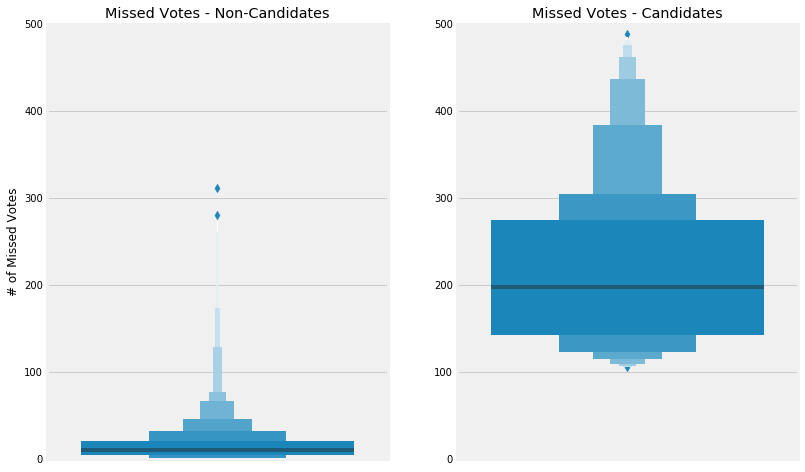

In [10]:
non_candidate_missed = []
candidate_missed = []
for session in range(102, 117):
    df = get_csv('senate', session)

    if session in sessions_to_ids.keys():
        candidate_ids = sessions_to_ids[session]
    else:
        candidate_ids = []

    data = get_csv('senate', session)    
    
    non_candidates = data[~data['id'].isin(candidate_ids)]
    non_candidate_missed.extend(non_candidates['missed_votes'])
        
    candidates = data[data['id'].isin(candidate_ids)]
    candidate_missed.extend(candidates['missed_votes'])
    

non_q = np.percentile(non_candidate_missed, [25, 50, 75])
non_min = np.min(non_candidate_missed)
non_max = np.max(non_candidate_missed)

cand_q = np.percentile(candidate_missed, [25, 50, 75])
cand_min = np.min(candidate_missed)
cand_max = np.max(candidate_missed)

print('5 Number Summary For the Senate')
print('102nd Congress - 116th Congress')
print('=================================')
print('    | Non-Candidates | Candidates')
print('----+----------------+-----------')
print('Min:|\t    %d\t     |     %d' % (non_min, cand_min))
print('Q1: |\t    %d\t     |     %d' % (non_q[0], cand_q[0]))
print('Med:|\t    %d       |     %d' % (non_q[1], cand_q[1]))
print('Q3: |\t    %d       |     %d' % (non_q[2], cand_q[2]))
print('Max:|\t    %d      |     %d' % (non_max, cand_max))
print('\n')

fig, ax = plt.subplots(1, 2, figsize=(12,8))
sns.boxenplot(non_candidate_missed, ax=ax[0], orient='v')
sns.boxenplot(candidate_missed, ax=ax[1], orient='v')
ax[0].set_title('Missed Votes - Non-Candidates')
ax[1].set_title('Missed Votes - Candidates')
ax[0].set_ylim(0, 500)
ax[1].set_ylim(0, 500);
ax[0].set_ylabel('# of Missed Votes');

There definitely appears to be a trend here. Let's conduct some hypothesis tests to see if this trend is statistically significant.

## Hypothesis Testing

From our exploratory data analysis, we noticed that senators that are running for President appear to miss more votes than their counterparts. Let's determine if this is statistically significant. We are going to run two hypothesis tests to confirm our intuition.

### Hypothesis Test 1
The first thing we want to learn is if the senators we have identified are indeed missing more votes than usual. We can confirm this by conducting an experiment comparing the average number of votes missed by these senators during their candidacies with the average number of votes missed by these senators otherwise. Let's formally state the hypotheses.

$$H_0: \mu_c = \mu_n$$
$$H_a: \mu_c > \mu_n$$

In these hypotheses, $\mu_c$ represents the average missed votes for senators when they are candidates, and $\mu_n$ represents the average missed votes for senators when they are not candidates.

In [11]:
cand_ids = set(['G000321', 'H000206', 'K000146', 'M000303', 'E000286', 
       'G000352', 'K000148', 'L000304', 'B000444', 'B000953', 
       'C001041', 'D000388', 'O000167', 'C001098', 'R000595', 
       'S000033', 'G000359', 'B001267', 'B001288', 'G000555', 
       'H001075', 'K000367', 'W000817'])
sessions_to_ids = {102: ['G000321', 'H000206', 'K000146'],
                   106: ['M000303'],
                   110: ['M000303', 'B000444', 'B000953', 'C001041', 'D000388', 'O000167'],
                   108: ['E000286', 'G000352', 'K000148', 'L000304'],
                   114: ['C001098', 'R000595', 'S000033', 'G000359'],
                   116: ['S000033', 'B001267', 'B001288', 'G000555', 'H001075', 'K000367', 'W000817']}

cand_votes = []
norm_votes = []
for session in range(101, 117):
    df = pd.read_csv('../congress-data/senate/senate_%d.csv' % session, index_col=0)
    
    if session in sessions_to_ids.keys():
        candidates = sessions_to_ids[session]
    else:
        candidates = []
        
    normal = cand_ids - set(candidates)
        
    normal_df = df[df['id'].isin(normal)]
    norm_votes.extend(normal_df['missed_votes'].values)
    
    cand_df = df[df['id'].isin(candidates)]
    cand_votes.extend(cand_df['missed_votes'].values)
    

In [12]:
print('Candidates Sample Size: %d' % (len(cand_votes)))
print('Not Candidate Sample Size: %d' % (len(norm_votes)))

Candidates Sample Size: 25
Not Candidate Sample Size: 138


Lets plot these samples in order to see their distribution. This will help us figure out which type of test to use.

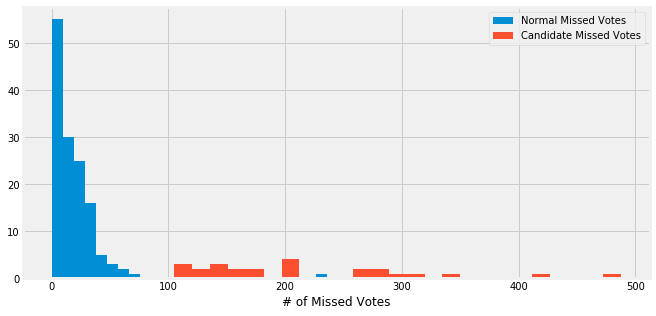

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(norm_votes, bins=25, label='Normal Missed Votes')
ax.hist(cand_votes, bins=25, label='Candidate Missed Votes')
ax.legend()
ax.set_xlabel('# of Missed Votes');

Neither of these really seem to follow a normal distribution, and since there is a large difference in sample sizes, it is safe to rule out using a t-test. Let's use a non-parametric test instead, the Mann-Whitney U-test.

Using the Mann-Whitney test means we should slightly adjust our null hypothesis. Now, our null hypothesis is as follows: the mean number of votes missed by senators running for President is equally likely to be higher than the mean number of votes missed by thhose senators when they are not running for President, and vice versa.

Formally, our null hypothesis looks like this:

$$P(\mu_n > \mu_c) = 0.5$$

$$\mu_c = \text{Candidate}$$
$$\mu_n = \text{Not Candidate}$$


For this experiment, our threshhold of an acceptable p-value is 0.05.

In [14]:
res = scs.mannwhitneyu(cand_votes, norm_votes, alternative='greater')
print('p-value for mu_c < mu_n: %.2f' % res.pvalue)

p-value for mu_c < mu_n: 0.00


With a p-value of essentially 0, we can say with 95% confidence that the mean number of votes missed by senators when they are running for president is higher than the mean number of votes missed by those same senators when they are not.

In other words, running for President as a sitting senator makes you more likely to miss votes.

## Hypothesis Test 2
Now that we have proved that senators running for President miss more votes than when they were not running for president, lets see if the same goes for comparing them with senators who chose not to run for President.

Let's formally state the hypotheses.

$$H_0: \mu_c = \mu_s$$
$$H_a: \mu_c > \mu_s$$

In these hypotheses, $\mu_c$ represents the average missed votes for senators when they are presidential candidates, and $\mu_s$ represents the average missed votes by senators who do not run for President.

In [15]:
cand_ids = set(['G000321', 'H000206', 'K000146', 'M000303', 'E000286', 
       'G000352', 'K000148', 'L000304', 'B000444', 'B000953', 
       'C001041', 'D000388', 'O000167', 'C001098', 'R000595', 
       'S000033', 'G000359', 'B001267', 'B001288', 'G000555', 
       'H001075', 'K000367', 'W000817'])

senator_votes = []
for session in range(101, 117):
    df = pd.read_csv('../congress-data/senate/senate_%d.csv' % session, index_col=0)
        
    senators_df = df[~df['id'].isin(cand_ids)]
    senator_votes.extend(senators_df['missed_votes'].values)

In [16]:
print('Candidates Sample Size: %d' % (len(cand_votes)))
print('Senators Sample Size: %d' % (len(senator_votes)))

Candidates Sample Size: 25
Senators Sample Size: 1485


The difference in sample size is so large that we know we should use a Mann-Whitney U-Test again. But let's plot the samples anyways.

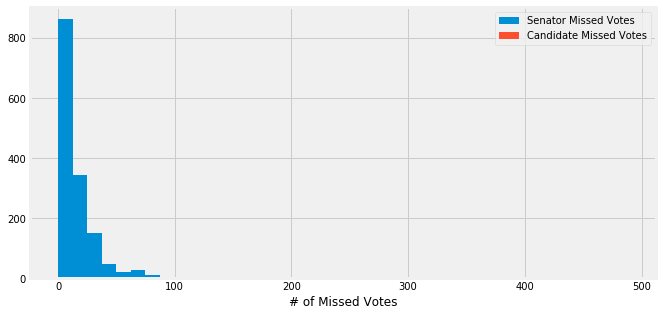

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(senator_votes, bins=25, label='Senator Missed Votes')
ax.hist(cand_votes, bins=25, label='Candidate Missed Votes')
ax.legend()
ax.set_xlabel('# of Missed Votes');

The samples for candidates don't even show up on the plot! That is because they are dwarfed on the y-axis by the other sample. This confirms that we should use a Mann-Whitney U-Test. Let's readjust our null hypothesis like we did before.

$$P(\mu_s > \mu_c) = 0.5$$

$$\mu_c = \text{Candidate}$$
$$\mu_s = \text{Other Senators}$$

Our p-value threshold will again be 0.05.

In [18]:
res = scs.mannwhitneyu(cand_votes, senator_votes, alternative='greater')
print('p-value for mu_c < mu_s: %.2f' % res.pvalue)

p-value for mu_c < mu_s: 0.00


Once again, we computed a very low p-value. In this case, we can say with 95% confidence that the mean numbers of votes missed by senators when they are running for President is higher than the mean nnumber of votes missed by other senators who do not run for President.

## Conclusion

The purpose of this project was to explore why a senator may miss a vote. In reality, senators may miss votes for any reason. Perhaps they fell ill, missed a flight, or were in a meeting. It is also worth considering that this project focused on the sheer number of votes missed, but not the actual content of those bills. I would imagine that senators tend to miss bills that are considered less important--both by their colleagues and the nation.

With that being said, it is safe to say that there is one factor that determines whether a senator will miss more votes in any give Congressional session: if they are running for President. Not only do they miss more votes that session than they have or will in other sessions, but they also miss more votes than their counterparts who do not run for President.

It may be worth considering allowing senators to send someone to vote in their place if they are running for President, since they miss votes so much.